In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt

In [2]:
np.random.seed(40)
tf.random.set_seed(40)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change the current working directory
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270


In [5]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [6]:
# Load Features
os.chdir('/content/drive/My Drive/Colab Notebooks/PINN_Active_Passive_Paper/p5270')
data1 = loadmat('Data.mat')
data2 = loadmat('Data.mat')
a_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2),'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel(),'physics_out':data1['physics_out'].ravel(),'ln_freqQAmpI_filt':data1['ln_freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['ShearStress'].ravel(), 'TTF':data1['TTF'].ravel()})
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2),'ln_V_V0':data2['ln_V_V0'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt','ln_freqQAmpI_filt', 'C_filt','ln_V_V0','Time','SS','TTF','physics_out']]
df_SS = df[['freqQAmpI_filt', 'C_filt', 'SS']]
df_TTF = df[['freqQAmpI_filt', 'C_filt', 'TTF']]
df_V = df[['freqQAmpI_filt', 'C_filt', 'ln_V_V0']]
df_PhyOut = df[['freqQAmpI_filt', 'C_filt', 'physics_out']]
df_A = df_A = df[['freqQAmpI_filt','C_filt','ln_freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','ln_V_V0']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS   ln_V_V0
0       5.651236 -2.068134
1       5.652434 -2.211235
2       5.653611 -2.173495
3       5.656168 -2.155145
4       5.656270 -2.119427
...          ...       ...
132394  5.465790 -2.378289
132395  5.463760 -2.211235
132396  5.465891 -2.312331
132397  5.464572 -2.401279
132398  5.463273 -2.035344

[132399 rows x 2 columns]


In [7]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (TTF)
arr = df_TTF.to_numpy()
n_steps = 300
xdf, ydf_TTF = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_SR = create_timesteps(arr, n_steps)
ydf_SR[ydf_SR < -2] = -2

# Preprocessing (Physics_Out)
arr = df_PhyOut.to_numpy()
n_steps = 300
xdf, phy_outdf = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, Adf = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, WVdf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (TTF), Y = ', np.shape(ydf_TTF))
print('Target shape (V), Y = ', np.shape(ydf_SR))
print('Target shape (A), Y = ', np.shape(Adf))
print('Target shape (WV), Y = ', np.shape(WVdf))
print('Target shape (Physics_Out), Y = ', np.shape(phy_outdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (TTF), Y =  (132099,)
Target shape (V), Y =  (132099,)
Target shape (A), Y =  (132099,)
Target shape (WV), Y =  (132099,)
Target shape (Physics_Out), Y =  (132099,)


In [8]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (TTF)
x_train, x_test, y_train_TTF, y_test_TTF = train_test_split(xdf, ydf_TTF, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_TTF, Y_val_TTF = train_test_split(x_train, y_train_TTF, test_size=0.125, shuffle=False)

# Split into train-val-test (SR)
x_train, x_test, y_train_SR, y_test_SR = train_test_split(xdf, ydf_SR, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SR, Y_val_SR = train_test_split(x_train, y_train_SR, test_size=0.125, shuffle=False)

# Split into train-val-test (A)
x_train, x_test, y_train_A, y_test_A = train_test_split(xdf, Adf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_A, Y_val_A = train_test_split(x_train, y_train_A, test_size=0.125, shuffle=False)

# Split into train-val-test (Physics Out)
x_train, x_test, y_train_Phy, y_test_Phy = train_test_split(xdf, phy_outdf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_Phy, Y_val_Phy = train_test_split(x_train, y_train_Phy, test_size=0.125, shuffle=False)

# Normalize the input
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))

Training: (92469, 300, 2)
Validation: (13210, 300, 2)
Testing: (26420, 300, 2)


In [9]:
# Normalize the output: SS
scaler_ss = MinMaxScaler(feature_range=(0, 1))
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [10]:
# Normalize the output: TTF
scaler_ttf = MinMaxScaler(feature_range=(0, 1))
Y_train_TTF = pd.DataFrame(scaler_ttf.fit_transform(Y_train_TTF.reshape(-1, 1)))
Y_val_TTF = pd.DataFrame(scaler_ttf.transform(Y_val_TTF.reshape(-1, 1)))
y_test_TTF = pd.DataFrame(scaler_ttf.transform(y_test_TTF.reshape(-1, 1)))

In [11]:
# # Normalize the output: SR
scaler_sr = MinMaxScaler(feature_range=(-1, 1))
Y_train_SR = pd.DataFrame(scaler_sr.fit_transform(Y_train_SR.reshape(-1, 1)))
Y_val_SR = pd.DataFrame(scaler_sr.transform(Y_val_SR.reshape(-1, 1)))
y_test_SR = pd.DataFrame(scaler_sr.transform(y_test_SR.reshape(-1, 1)))

In [12]:
# Normalize Amp
scaler_A = MinMaxScaler(feature_range=(0, 1))
Y_train_A = pd.DataFrame(scaler_A.fit_transform(Y_train_A.reshape(-1, 1)))
Y_val_A = pd.DataFrame(scaler_A.transform(Y_val_A.reshape(-1, 1)))
y_test_A = pd.DataFrame(scaler_A.transform(y_test_A.reshape(-1, 1)))

In [13]:
# Define Physics
# Rate and State Friction
# mu  = mu0 + a*ln(V/V0)+ b*ln(V0*Theta/Dc)
# SS = C1 + C2ln(V/V0) + C3ln(V0*Theta/Dc)

class gradient_1(tf.keras.layers.Layer):
  def __init__(self):
    super(gradient_1,self).__init__()
    self.SS = tf.keras.layers.Dense(1)
    self.SR = tf.keras.layers.Dense(1)
    self.A = tf.keras.layers.Dense(1)
    self.all_scale = tf.keras.layers.Dense(1)
    self.c1 = self.add_weight("c1",trainable=True)
    self.c2 = self.add_weight("c2",trainable=True)
    self.c3 = self.add_weight("c3",trainable=True)
    self.c4 = self.add_weight("c4",trainable=True)
  def call(self, params):
    ss_pred, sr_pred, Amp = params
    ss_pred = self.SS(ss_pred)
    sr_pred = self.SR(sr_pred)
    Amp = self.A(Amp)

    term1 =  ss_pred
    term2 =  sr_pred
    term3 =  Amp - self.c4

    term4 = tf.multiply(self.c2,term2)
    term5 = tf.multiply(self.c3,term3)

    eqn = term1-self.c1-term4-term5
    eqn = self.all_scale(eqn)

    return eqn

Train on 92469 samples, validate on 13210 samples
Epoch 1/10
92469/92469 [==============================] - ETA: 0s - loss: 0.1379 - ss_loss: 0.0184 - ttf_loss: 0.0288 - sr_loss: 0.0864 - gradient_1_loss: 0.0043 - ss_mse: 0.0184 - ttf_mse: 0.0288 - sr_mse: 0.0864 - gradient_1_mse: 0.0043

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


92469/92469 [==============================] - 850s 9ms/sample - loss: 0.1379 - ss_loss: 0.0184 - ttf_loss: 0.0288 - sr_loss: 0.0864 - gradient_1_loss: 0.0043 - ss_mse: 0.0184 - ttf_mse: 0.0288 - sr_mse: 0.0864 - gradient_1_mse: 0.0043 - val_loss: 0.0203 - val_ss_loss: 0.0019 - val_ttf_loss: 0.0074 - val_sr_loss: 0.0110 - val_gradient_1_loss: 2.5748e-18 - val_ss_mse: 0.0019 - val_ttf_mse: 0.0074 - val_sr_mse: 0.0110 - val_gradient_1_mse: 2.5746e-18
Epoch 2/10
92469/92469 [==============================] - 847s 9ms/sample - loss: 0.0149 - ss_loss: 0.0012 - ttf_loss: 0.0041 - sr_loss: 0.0096 - gradient_1_loss: 1.5695e-20 - ss_mse: 0.0012 - ttf_mse: 0.0041 - sr_mse: 0.0096 - gradient_1_mse: 1.5697e-20 - val_loss: 0.0198 - val_ss_loss: 0.0017 - val_ttf_loss: 0.0050 - val_sr_loss: 0.0131 - val_gradient_1_loss: 0.0000e+00 - val_ss_mse: 0.0017 - val_ttf_mse: 0.0050 - val_sr_mse: 0.0131 - val_gradient_1_mse: 0.0000e+00
Epoch 3/10
92469/92469 [==============================] - 845s 9ms/sample -

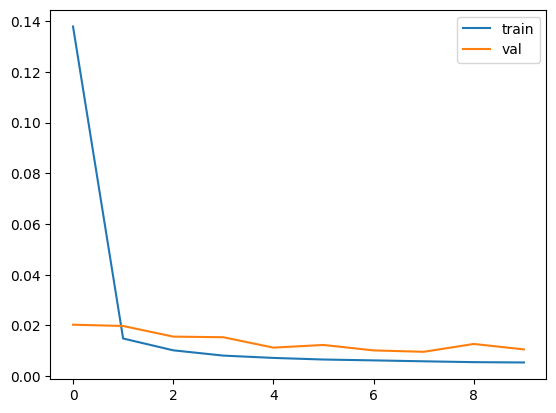

---Training time: 8500.06723022 seconds ---


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Shear Stress
R2 scores: Train - 0.98461, Validation - 0.97228
RMSE scores: Train - 0.01920, Validation - 0.02989

TTF
R2 scores: Train - 0.96484, Validation - 0.93543
RMSE scores: Train - 0.04313, Validation - 0.06425

SR
R2 scores: Train - 0.98140, Validation - 0.96084
RMSE scores: Train - 0.05351, Validation - 0.07439


In [14]:
# Build the model
# inputs
inp = Input(shape=(X_train.shape[1], X_train.shape[2]), name='inp')
Amp =layers.Input(shape=(1),name='Amp')

## SS + TTF + SR
m = LSTM(64, activation='tanh', return_sequences=True)(inp)
m = LSTM(32, activation='tanh')(m)
ss = Dense(1, kernel_initializer='normal', activation='linear', name='ss')(m)
ttf = Dense(1, kernel_initializer='normal', activation='linear', name='ttf')(m)
sr = Dense(1, kernel_initializer='normal', activation='linear', name='sr')(m)

grad_out = gradient_1()([ss,sr,Amp])

model = Model(inputs=[inp,Amp], outputs=[ss,ttf,sr,grad_out])

model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(1e-3), metrics=['mse'])

start_time = time.time()
history = model.fit([X_train,Y_train_A], [Y_train_SS, Y_train_TTF, Y_train_SR, Y_train_Phy], epochs=10, batch_size=32,
                    validation_data=([X_val,Y_val_A], [Y_val_SS, Y_val_TTF, Y_val_SR, Y_val_Phy]), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

y_predTrain = model.predict([X_train,Y_train_A])
ss_train_r2 = r2_score(Y_train_SS, y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train_SS, y_predTrain[0]))
ttf_train_r2 = r2_score(Y_train_TTF, y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train_TTF, y_predTrain[1]))
sr_train_r2 = r2_score(Y_train_SR, y_predTrain[2])
sr_train_rmse = np.sqrt(mean_squared_error(Y_train_SR, y_predTrain[2]))

y_predVal = model.predict([X_val,Y_val_A])
ss_val_r2 = r2_score(Y_val_SS, y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val_SS, y_predVal[0]))
ttf_val_r2 = r2_score(Y_val_TTF, y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val_TTF, y_predVal[1]))
sr_val_r2 = r2_score(Y_val_SR, y_predVal[2])
sr_val_rmse = np.sqrt(mean_squared_error(Y_val_SR, y_predVal[2]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f" %(ss_train_r2, ss_val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(ss_train_rmse, ss_val_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f" %(ttf_train_r2, ttf_val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(ttf_train_rmse, ttf_val_rmse))

print("\nSR\nR2 scores: Train - %0.5f, Validation - %0.5f" %(sr_train_r2, sr_val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(sr_train_rmse, sr_val_rmse))

In [15]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inp (InputLayer)            [(None, 300, 2)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 300, 64)              17152     ['inp[0][0]']                 
                                                                                                  
 lstm_1 (LSTM)               (None, 32)                   12416     ['lstm[0][0]']                
                                                                                                  
 ss (Dense)                  (None, 1)                    33        ['lstm_1[0][0]']              
                                                                                              

In [16]:
# Evaluate the model

start_time = time.time()
y_predTest = model.predict([x_test,y_test_A])
end_time = time.time()
ss_test_r2 = r2_score(y_test_SS, y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test_SS, y_predTest[0]))
ttf_test_r2 = r2_score(y_test_TTF, y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test_TTF, y_predTest[1]))
sr_test_r2 = r2_score(y_test_SR, y_predTest[2])
sr_test_rmse = np.sqrt(mean_squared_error(y_test_SR, y_predTest[2]))

print("Test -\nShear Stress\nR2 scores:  %0.5f \nRMSE scores: %0.5f" %(ss_test_r2, ss_test_rmse))
print("\nTTF\nR2 scores: %0.5f\nRMSE scores: %0.5f" %(ttf_test_r2, ttf_test_rmse))
print("\nSR\nR2 scores: %0.5f\nRMSE scores: %0.5f" %(sr_test_r2, sr_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

Test -
Shear Stress
R2 scores:  0.94567 
RMSE scores: 0.04099

TTF
R2 scores: 0.91725
RMSE scores: 0.07277

SR
R2 scores: 0.92562
RMSE scores: 0.10251

---Time for Test data prediction: 56.10462022 seconds ---


In [17]:
# Inverse scaling: SS
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predTrain[0])
y_predval_SS = scaler_ss.inverse_transform(y_predVal[0])
y_predtest_SS = scaler_ss.inverse_transform(y_predTest[0])

In [18]:
# Inverse scaling: TTF
Y_train_TTF = scaler_ttf.inverse_transform(Y_train_TTF)
Y_val_TTF = scaler_ttf.inverse_transform(Y_val_TTF)
y_test_TTF = scaler_ttf.inverse_transform(y_test_TTF)
y_predtrain_TTF = scaler_ttf.inverse_transform(y_predTrain[1])
y_predval_TTF = scaler_ttf.inverse_transform(y_predVal[1])
y_predtest_TTF = scaler_ttf.inverse_transform(y_predTest[1])

In [19]:
# Inverse scaling: SR
Y_train_SR = scaler_sr.inverse_transform(Y_train_SR)
Y_val_SR = scaler_sr.inverse_transform(Y_val_SR)
y_test_SR = scaler_sr.inverse_transform(y_test_SR)
y_predtrain_SR = scaler_sr.inverse_transform(y_predTrain[2])
y_predval_SR = scaler_sr.inverse_transform(y_predVal[2])
y_predtest_SR = scaler_sr.inverse_transform(y_predTest[2])

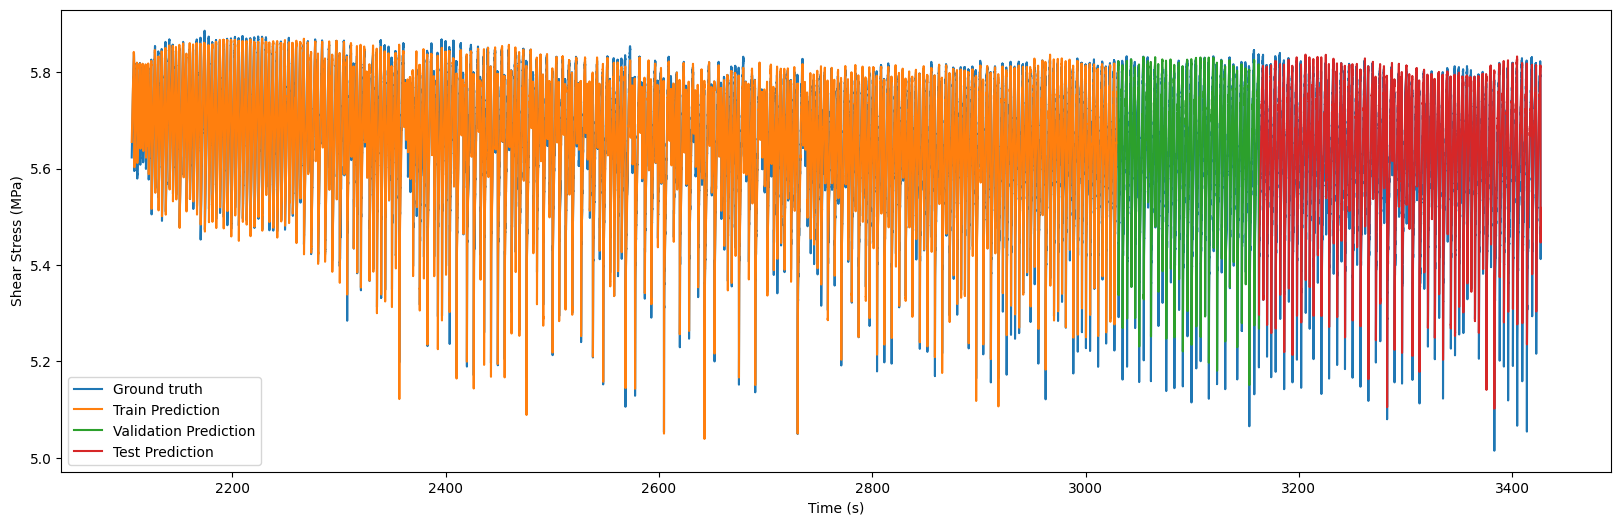

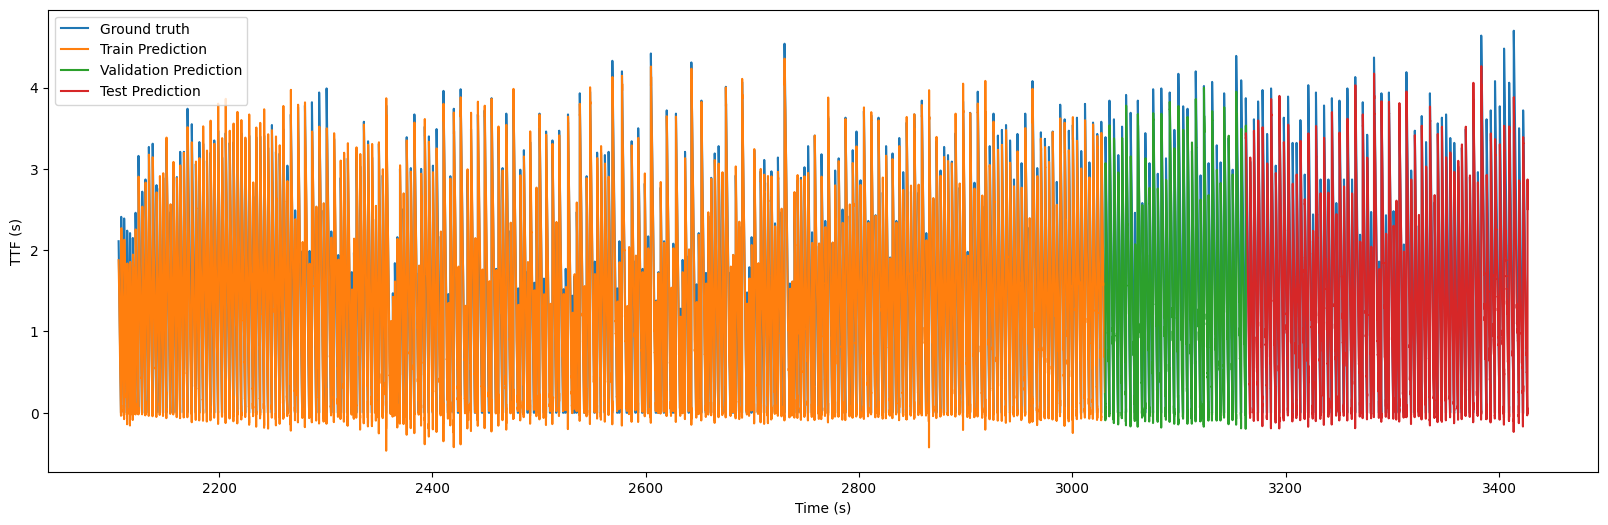

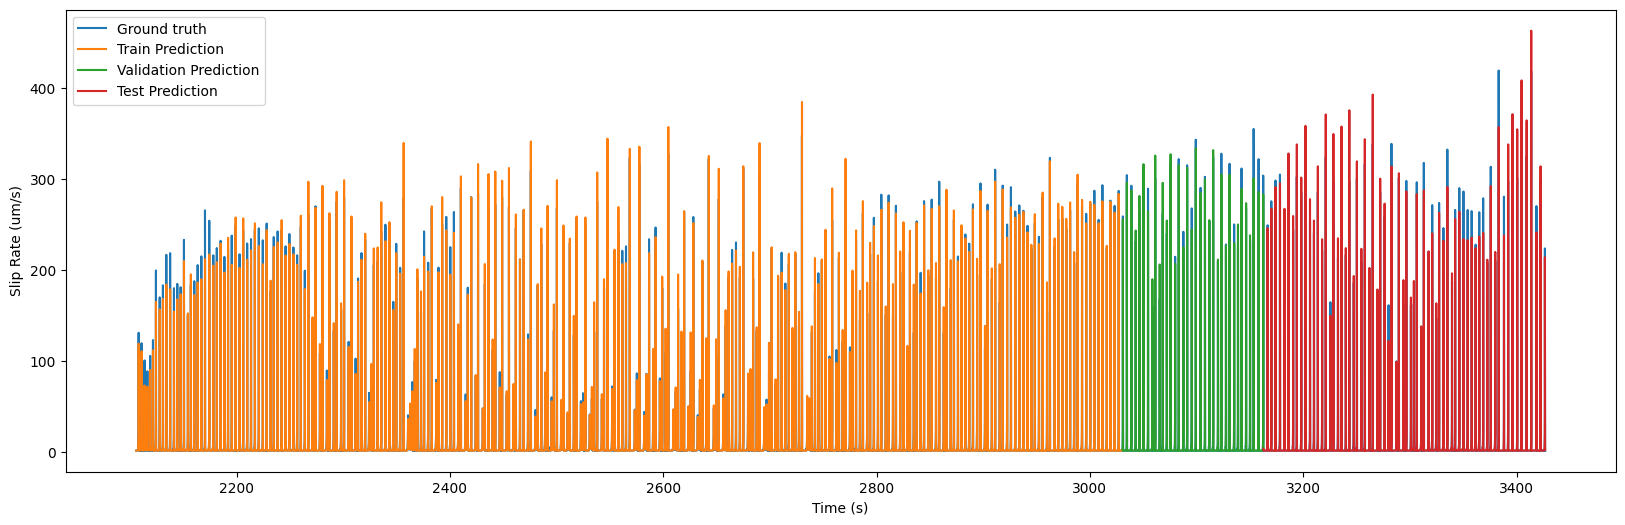

In [20]:
# Overall plot:
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_TTF)
plt.plot(traintime, y_predtrain_TTF)
plt.plot(valtime,  y_predval_TTF)
plt.plot(testtime, y_predtest_TTF)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

ydf_SR = np.exp(ydf_SR)*10;
y_predtrain_SR = np.exp(y_predtrain_SR)*10;
y_predval_SR = np.exp(y_predval_SR)*10;
y_predtest_SR = np.exp(y_predtest_SR)*10;

fig = plt.figure(3, figsize=(20,6))
plt.plot(ttime, ydf_SR)
plt.plot(traintime, y_predtrain_SR)
plt.plot(valtime,  y_predval_SR)
plt.plot(testtime, y_predtest_SR)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

In [21]:
# # Extract Weights
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

lstm/lstm_cell/kernel:0 (2, 256)
lstm/lstm_cell/recurrent_kernel:0 (64, 256)
lstm/lstm_cell/bias:0 (256,)
lstm_1/lstm_cell/kernel:0 (64, 128)
lstm_1/lstm_cell/recurrent_kernel:0 (32, 128)
lstm_1/lstm_cell/bias:0 (128,)
ss/kernel:0 (32, 1)
ss/bias:0 (1,)
sr/kernel:0 (32, 1)
sr/bias:0 (1,)
ttf/kernel:0 (32, 1)
ttf/bias:0 (1,)
c1:0 ()
c2:0 ()
c3:0 ()
c4:0 ()
gradient_1/dense/kernel:0 (1, 1)
gradient_1/dense/bias:0 (1,)
gradient_1/dense_1/kernel:0 (1, 1)
gradient_1/dense_1/bias:0 (1,)
gradient_1/dense_2/kernel:0 (1, 1)
gradient_1/dense_2/bias:0 (1,)
gradient_1/dense_3/kernel:0 (1, 1)
gradient_1/dense_3/bias:0 (1,)


In [22]:
# # Display Weights
model.get_weights()

[array([[ 4.62038606e-01, -7.68224716e-01,  1.21591523e-01,
          1.42781079e-01, -5.78098483e-02, -3.10707003e-01,
         -3.26553822e-01, -3.82746249e-01,  6.25027061e-01,
          3.37725550e-01, -5.60723662e-01,  1.78383887e-02,
         -2.61980057e-01, -2.62134671e-01,  1.06652938e-01,
          3.44661236e-01,  8.15408468e-01,  3.55149776e-01,
         -1.27013579e-01, -3.44396383e-01, -4.35214899e-02,
         -2.81507522e-01, -2.12168321e-01, -3.58320981e-01,
         -1.32367656e-01, -1.34132475e-01, -6.48550913e-02,
         -1.59581855e-01,  7.50931501e-01, -3.66282970e-01,
          7.86132645e-03, -1.62747383e-01, -1.10227726e-01,
          4.75361720e-02, -4.99421865e-01, -5.15568376e-01,
         -1.51447989e-02, -5.96280098e-01, -3.99392456e-01,
          4.07013372e-02, -5.00515819e-01, -4.16103095e-01,
         -4.00786281e-01, -2.24689066e-01, -4.46044773e-01,
         -2.60610133e-01, -3.86408955e-01,  1.38197988e-02,
         -1.00955985e-01,  2.05275342e-0

In [23]:
# # Get scale
print(scaler_ss.scale_)
print(scaler_sr.scale_)
print(scaler_A.scale_)
r2 = scaler_A.scale_.max()
print(r2)

[1.19521341]
[0.36035841]
[6.20816438]
6.208164382200324


In [28]:
# # # # Rescale constant C1
cols = ['C1']
data = pd.DataFrame(np.array([[1.2755313]]),columns=cols)
a = scaler_ss.inverse_transform(data)
Mu0 = a/10
print(Mu0)

[[0.61163893]]


In [29]:
# # # # # Rescale constant C2
r1 = 1e-3
cols = ['a']
data = pd.DataFrame(np.array([[1.0220796]]),columns=cols)
a = scaler_sr.inverse_transform(data)
a = a*r1
print(a)

[[0.0036113]]


In [30]:
# # # # # Rescale constant C3
cols = ['a']
data = pd.DataFrame(np.array([[1.6496193]]),columns=cols)
b = scaler_A.inverse_transform(data)
b = b*r1
print(b)

[[0.01284834]]


In [31]:
# # # # Rescale constant C4
Dc= math.exp(0.4424994)
print(Dc)

1.5565929088576835
